In [1]:
%matplotlib widget
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as sig
import seaborn as sns


#plt.style.use('ggplot')
plt.style.use('seaborn-v0_8')

#sns.set_style('white')

In [2]:
import funcs.signals as signals

In [3]:
# --- 1. Configuration and Data Loading ---
spikes = np.load('data/spikes-10e4-ms_7.npy')
tau = 100
selected_neuron = 50

sg_window_len = 31

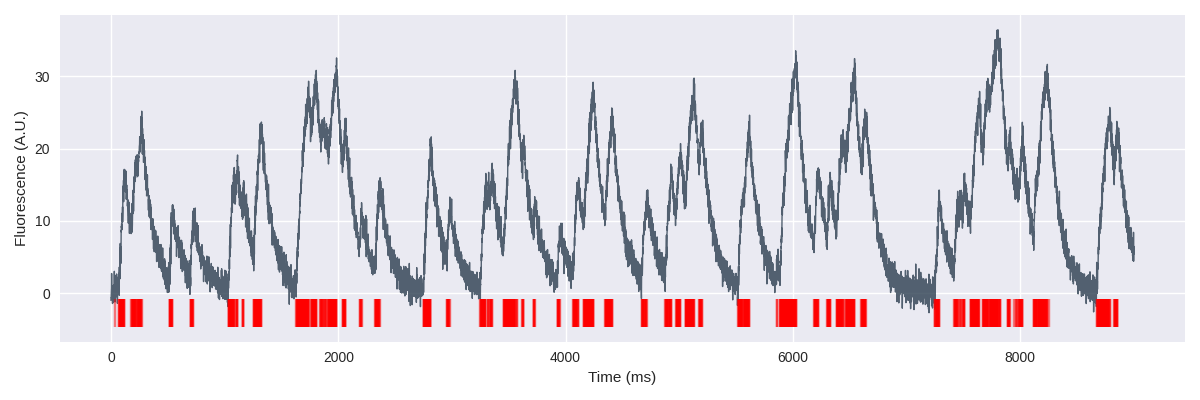

In [4]:
# --- 2. Simulation ---
# Using baseline=0.0 and return_df_f=False to keep the signal in "Spike Units"
calcium_data, spikes_cropped = signals.simulate_calcium(
    spikes,
    tau=tau,
    baseline=0.0,       # Sets baseline to zero to avoid phantom spike offsets
    noise_intra=0.01,   # Internal biological noise
    noise_rec=1.0,      # External recording noise (e.g., camera sensor)
    return_df_f=False,  # Keep raw scale
    plot=True,
    neuron_idx=selected_neuron
)

In [5]:
reconstructed_spikes = signals.reconstruct_spikes(
    calcium_data, tau=tau, window_len=sg_window_len
)

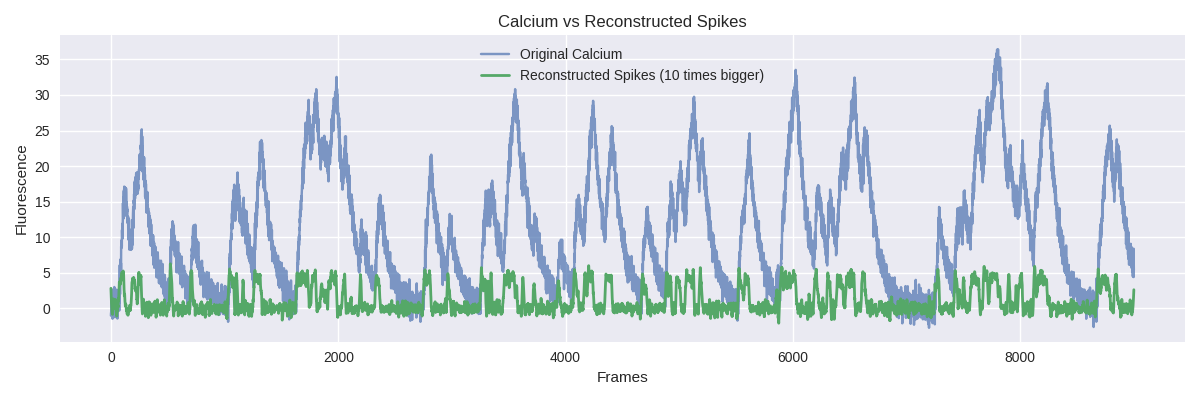

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(calcium_data[selected_neuron], label='Original Calcium', alpha=0.7)
plt.plot(10*reconstructed_spikes[selected_neuron], label='Reconstructed Spikes (10 times bigger)', linewidth=2)
plt.xlabel('Frames')
plt.ylabel('Fluorescence')
plt.title('Calcium vs Reconstructed Spikes')
plt.legend()
plt.tight_layout()
plt.show()


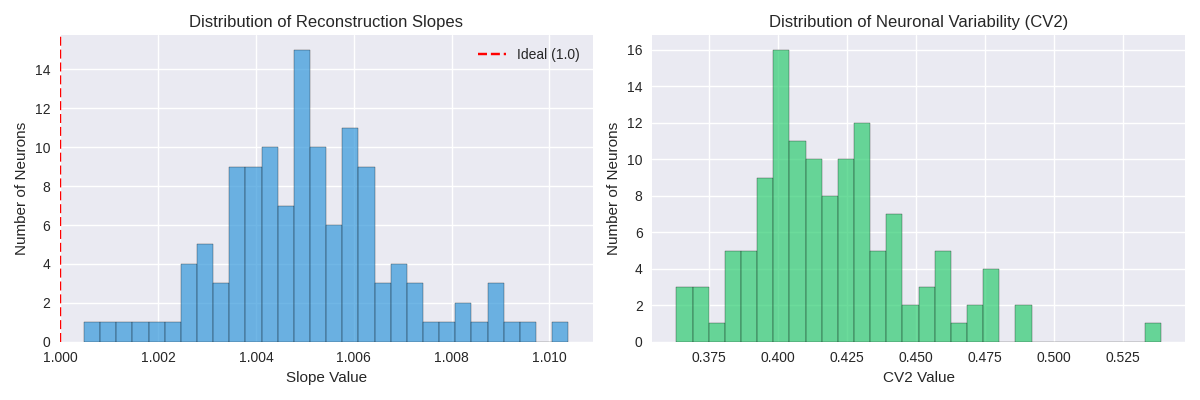

Mean Population Slope: 1.0051
Mean Population CV2: 0.4200


In [7]:
# --- 2. Population Calculations ---
slopes = signals.cumsum_analysis(spikes_cropped, reconstructed_spikes)
cv2s = signals.calculate_cv2(spikes_cropped)

# --- 3. Plotting Histograms ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Slope Histogram
# We drop NaNs to ensure the histogram can plot correctly
clean_slopes = slopes[~np.isnan(slopes)]
ax1.hist(clean_slopes, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(1.0, color='red', linestyle='--', label='Ideal (1.0)')
ax1.set_title("Distribution of Reconstruction Slopes")
ax1.set_xlabel("Slope Value")
ax1.set_ylabel("Number of Neurons")
ax1.legend()

# CV2 Histogram
clean_cv2s = cv2s[~np.isnan(cv2s)]
ax2.hist(clean_cv2s, bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.set_title("Distribution of Neuronal Variability (CV2)")
ax2.set_xlabel("CV2 Value")
ax2.set_ylabel("Number of Neurons")

plt.tight_layout()
plt.show()

# --- 4. Statistics Summary ---
print(f"Mean Population Slope: {np.nanmean(slopes):.4f}")
print(f"Mean Population CV2: {np.nanmean(cv2s):.4f}")

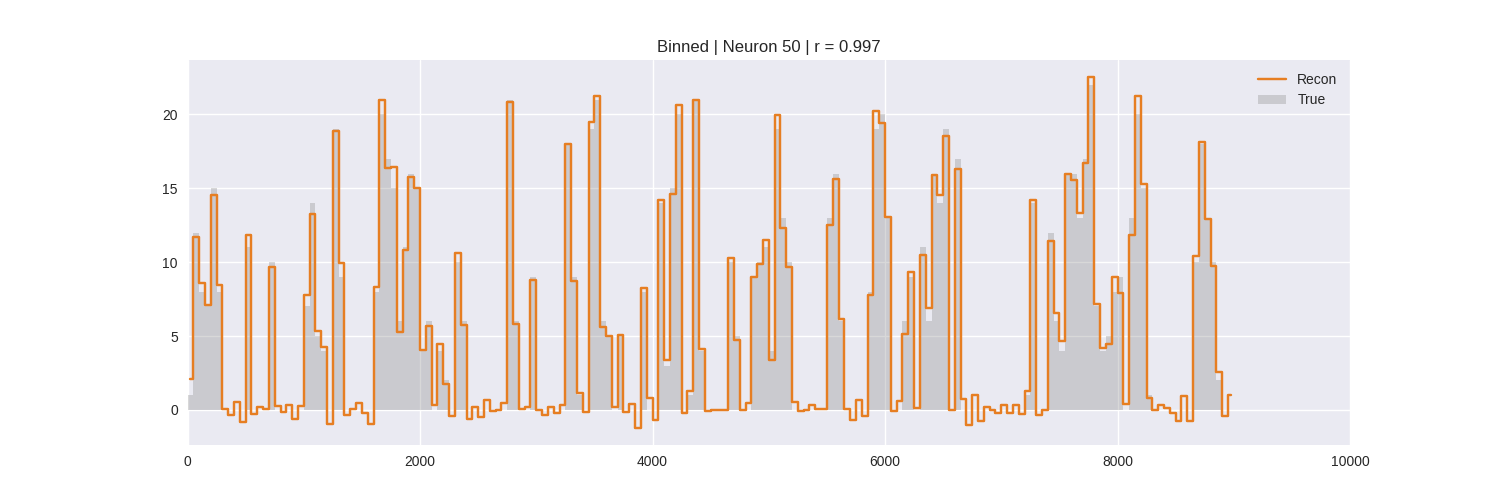

In [8]:
correlations = signals.analyze_binned_performance(
    spikes_cropped, 
    reconstructed_spikes, 
    bin_size=50, 
    neuron_idx=selected_neuron, 
    plot=True,
    time_limit=(0, 10000)
)

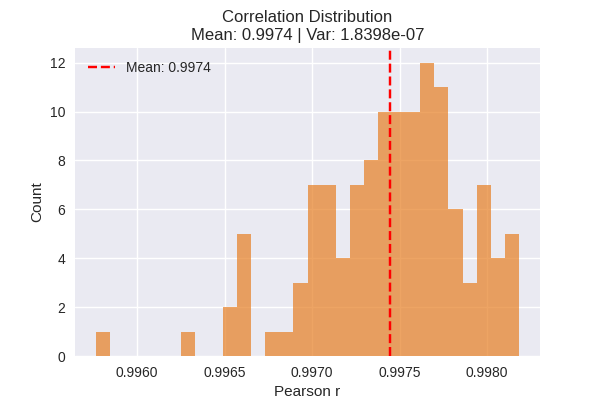

Mean Correlation: 0.9974
Correlation Variance: 1.8398e-07


In [9]:
# --- 3. Additional Population Histogram ---
clean_corrs = correlations[~np.isnan(correlations)]
mean_corr = np.mean(clean_corrs)
var_corr = np.var(clean_corrs)

plt.figure(figsize=(6, 4))
plt.hist(clean_corrs, bins=30, color='#e67e22', alpha=0.7)

# Add visual markers for stats
plt.axvline(mean_corr, color='red', linestyle='--', label=f'Mean: {mean_corr:.4f}')
plt.title(f"Correlation Distribution\nMean: {mean_corr:.4f} | Var: {var_corr:.4e}")
plt.xlabel("Pearson r"); plt.ylabel("Count")
plt.legend()
plt.show()

print(f"Mean Correlation: {mean_corr:.4f}")
print(f"Correlation Variance: {var_corr:.4e}")

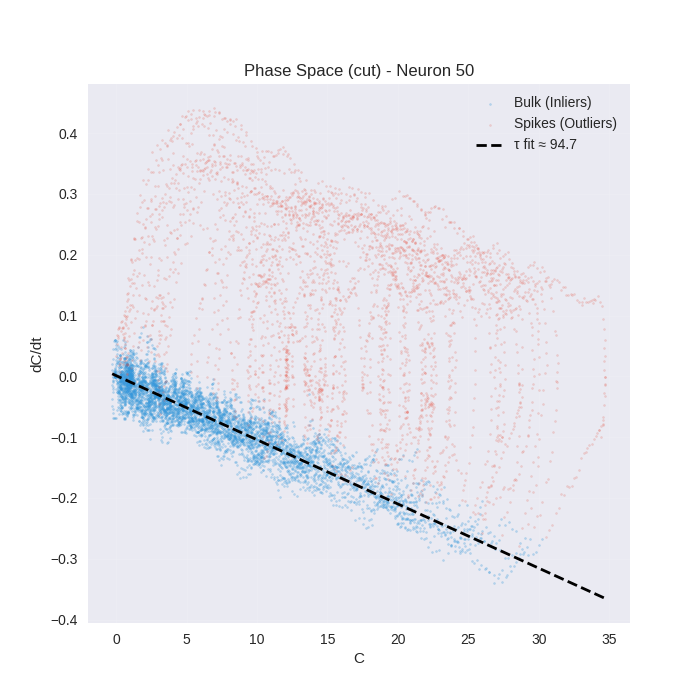

In [10]:
tau_cut = signals.estimate_tau(
    calcium_data,
    true_spikes=spikes_cropped,
    neuron_indices=selected_neuron,
    method='cut',
    neuron_idx=selected_neuron)

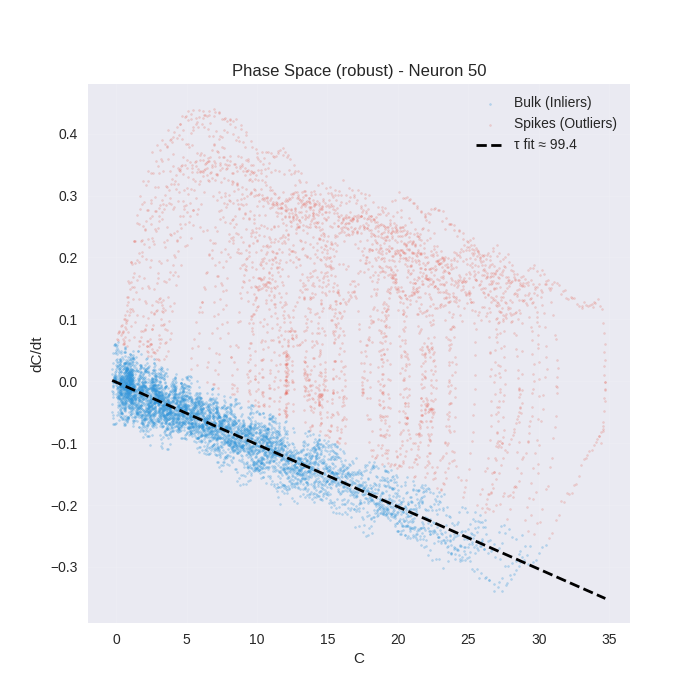

In [11]:
tau_cut = signals.estimate_tau(
    calcium_data,
    true_spikes=spikes_cropped,
    neuron_indices=selected_neuron,
    method='robust',
    neuron_idx=selected_neuron)